In [1]:
import pandas
uri = "https://www.mhlw.go.jp/content/pcr_positive_daily.csv"
try:
    data = pandas.read_csv(pcr_positive_daily)
    data.to_csv('recent_cache_' + uri.rsplit('/',1)[1])
except:
    data = pandas.read_csv('recent_cache_' + uri.rsplit('/',1)[1])
data['日付'] = pandas.to_datetime(data['日付'])
data.set_index('日付',inplace = True)
data.drop(['Unnamed: 0'], axis = 1, inplace = True)
data['PCR 検査陽性者数(7日間移動平均)'] = data['PCR 検査陽性者数(単日)'].rolling(7).mean()
data

,PCR 検査陽性者数(単日),PCR 検査陽性者数(7日間移動平均)
日付,,
2020-01-16,1,NaN
2020-01-17,0,NaN
2020-01-18,0,NaN
2020-01-19,0,NaN
2020-01-20,0,NaN
...,...,...
2021-07-23,4204,3935.571429
2021-07-24,3576,3893.428571
2021-07-25,5009,4167.142857


/home/loupsgarous/.local/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/loupsgarous/.local/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_div

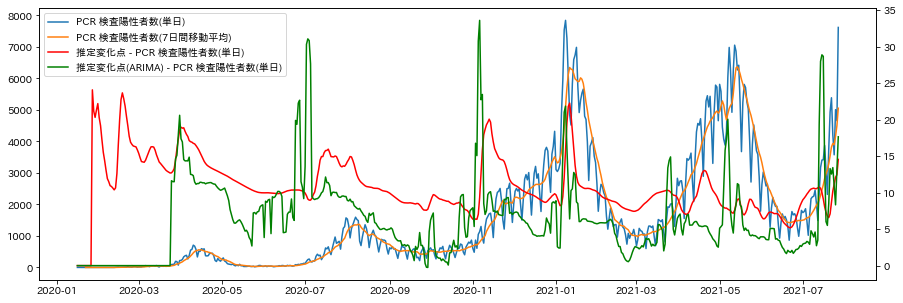

In [2]:
import matplotlib
import matplotlib.pyplot
import changefinder

class changefinder_calculator():
    def __init__(self, data):
        self.data = data
    def changefinder_calculator(self, column):
        cf = changefinder.ChangeFinder(r=0.05, order=1, smooth=7)
        ret = []
        for i in self.data[column]:
            score = cf.update(i)
            ret.append(score)
        return ret

    def changefinderARIMA_calculator(self, column):
        cf = changefinder.ChangeFinderARIMA()
        ret = []
        for i in self.data[column]:
            score = cf.update(i)
            ret.append(score)
        return ret

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
# print(data)
fig = matplotlib.pyplot.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)

ax1.plot(data, label = data.columns)

# data['変化点スコア - PCR 検査陽性者数(単日)'] = changefinder_calculator('PCR 検査陽性者数(単日)')

ax2 = ax1.twinx()

cc = changefinder_calculator(data)

ax2.plot(data.index,
         cc.changefinder_calculator('PCR 検査陽性者数(単日)'),
         label = '推定変化点 - PCR 検査陽性者数(単日)',
         color = 'r')
ax2.plot(data.index,
         cc.changefinderARIMA_calculator('PCR 検査陽性者数(単日)'),
         label = '推定変化点(ARIMA) - PCR 検査陽性者数(単日)',
         color = 'g')


hans1, labs1 = ax1.get_legend_handles_labels()
hans2, labs2 = ax2.get_legend_handles_labels()

ax1.legend(hans1+hans2, labs1+labs2)

matplotlib.pyplot.show()

In [3]:
df_norm = data
df = df_norm.dropna()
print('Number of records: ', len(data), '->', len(df))
df[:5]

mean = df.mean(axis=0)
std = df.std(axis=0)
for i in df.columns:
    df_norm[i] = (df_norm[i] - mean[i]) / std[i]
    df[i] = (df[i] - mean[i]) / std[i]

df[:5]

Number of records:  559 -> 553


/home/loupsgarous/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,PCR 検査陽性者数(単日),PCR 検査陽性者数(7日間移動平均)
日付,,
2020-01-22,-0.904293,-0.928624
2020-01-23,-0.904293,-0.928710
2020-01-24,-0.903721,-0.928624
2020-01-25,-0.903721,-0.928539
2020-01-26,-0.903721,-0.928453


[graphical_lasso] Iteration   0, cost  9.33e+00, dual gap 1.427e-01
[graphical_lasso] Iteration   1, cost  9.32e+00, dual gap -5.551e-16


<AxesSubplot:title={'center':'Estimated precision'}>

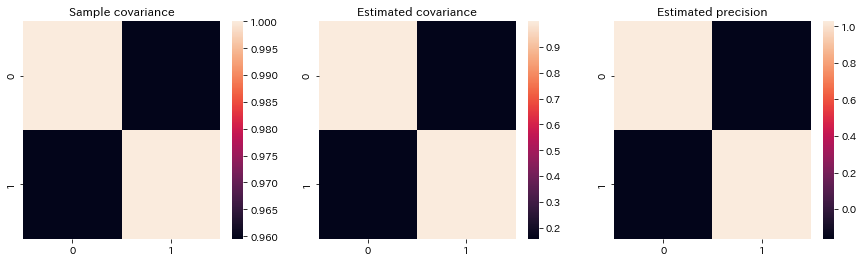

In [4]:
import sklearn.covariance
import numpy
import seaborn
model = sklearn.covariance.GraphicalLasso(alpha=0.8, verbose=True)
model.fit(df)
cov = numpy.cov(df, rowvar=0)
cov_ = model.covariance_
pre_ = model.precision_

f, axes = matplotlib.pyplot.subplots(1, 3, figsize=(15, 4))
axes[0].set_title('Sample covariance')
axes[1].set_title('Estimated covariance')
axes[2].set_title('Estimated precision')

seaborn.heatmap(cov, ax=axes[0])
seaborn.heatmap(cov_, ax=axes[1])
seaborn.heatmap(pre_, ax=axes[2])

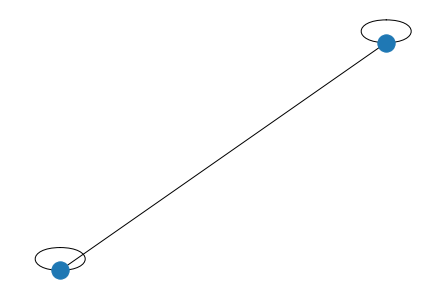

In [5]:
import networkx
graph = networkx.from_numpy_matrix(pre_)
networkx.draw(graph)

In [6]:
import math

df_scores = pandas.DataFrame(columns=df_norm.columns)

for t in df_norm.index:
    row = []
    for i in range(38):
        acc = 0
        for j in range(38):
            if not math.isnan(df_norm[j + 1][t]):
                acc += pre_[i][j] * df_norm[j + 1][t]
        acc = acc**2
        score = 0.5 * math.log(2*math.pi/pre_[i][i]) + 0.5 / pre_[i][i] * acc
        row.append(score)
    df_scores.loc[t] = row

df_scores[:5]

KeyError: 1